# Rotation period of tracklets

In this notebook, we try to estimate the rotation period of tracklets around the Earth

In [636]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import numpy as np

from tqdm.auto import tqdm

from astropy.table import Table, vstack
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord, concatenate, get_sun

from fink_science.conversion import dc_mag

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tracklet identification

Let's load the raw tracklet data from Fink (initial candidates) for the year 2020

In [637]:
from fastparquet import ParquetFile

pdt = ParquetFile('ufo_fink_2020_consolidated/part-00000-bd9449f3-af4a-49e8-aa7c-4bdbf1cce3e4-c000.snappy.parquet').to_pandas()

table = Table.from_pandas(pdt)

# We keep only candidates with 1 detection
table = table[table['ndethist'] == 1]
len(table)

489755

Based on Sergey's analysis, let's limit the analysis to the candidates outside the locus of bad subtractions

In [638]:
idx = table['magnr'] - table['magpsf'] < 3.0*np.hypot(table['sigmagnr'], table['sigmapsf'])
idx &= table['magnr'] - table['magpsf'] < -4*(np.log10(table['distnr']) + 0.2)
idx &= table['distnr'] < 2

table1 = table[~idx]

Let's now extract all groups of candidates laying along great circles - tracklets -- having at least 5 points using Sergey's extraction method. The criterion will be the distance from great circle less than 1 arcsecond. As a candidate circles, we will use all possible circles passing through pairs of points.

In [639]:
N = 0

# Boolean
table1['tracklet'] = False

# Integer - container for tracklet designation
table1['tracklet_number'] = 0

tracklets = []

key = 'nid' # Analyse night at once
# key = 'jd' # Analyse single frames

for nid in tqdm(sorted(np.unique(table1[key]))[:]):
    idx = table1[key] == nid

    sub = table1[idx] # Subset of objects from this exposure
    coords = SkyCoord(sub['ra'], sub['dec'], unit='deg') # Coordinates of the objects
    xyz = coords.cartesian
    xyz = xyz.xyz.value.T # unit vectors corresponding to the points, Nx3
    
    if len(sub) < 5:
        continue

    # Levi-Civitta symbol
    eijk = np.zeros((3, 3, 3))
    eijk[0, 1, 2] = eijk[1, 2, 0] = eijk[2, 0, 1] = 1
    eijk[0, 2, 1] = eijk[2, 1, 0] = eijk[1, 0, 2] = -1

    circles = np.einsum('ijk,uj,vk->uvi', eijk, xyz, xyz, optimize=True) # cross-products, NxNx3
    norms = np.sqrt(np.einsum('uvi,uvi->uv', circles, circles, optimize=True)) # norms, i.e. arc sine lengths, NxN
    norms = np.tril(norms) # Remove redundant entries corresponding to the symmetry on point swapping

    norm_idx = norms > 10/206265 # Pairs with angular separation larger than 10 arcsec, NxN
    
    circles[norms==0,:] = 0
    circles[norms>0,:] /= norms[norms>0,np.newaxis] # normals to great circles, NxNx3

    cidxs = [] # Sets of points along great circles 
    
    for i,point in enumerate(xyz):
        sindists = np.einsum('vi,ki->vk', circles[i], xyz, optimize=True) # sine distance from the great circle
        sin_idx = np.abs(sindists) < 1/206265 # Good distances from great circles, NxN

        nps = np.einsum('uv->u', (norm_idx[i,:,np.newaxis] & sin_idx).astype(np.int8), optimize=True) # Numbers of points along each great circle, N
        np_idx = nps >= 5

        cidxs += list(sin_idx[np_idx])
        
    uniq = np.unique(cidxs, axis=0)
    aidx = np.argsort([-np.sum(_) for _ in uniq])

    used = np.zeros(len(sub), dtype=bool)

    for index_tracklet, cidx in enumerate(uniq[aidx]):
        # First we need to reject the tracklets mostly superceded by longer ones
        if np.sum(cidx[~used]) < 5: 
            # TODO: should we try to greedily merge the extra points into already known tracks?
            continue 

        used[cidx] = True
        N += 1

        table1['tracklet'][np.where(idx)[0][cidx]] = True
        table1['tracklet_number'][np.where(idx)[0][cidx]] = index_tracklet
        
        tracklets.append(np.where(idx)[0][cidx])

  0%|          | 0/272 [00:00<?, ?it/s]

In [640]:
# Index for candidates belonging to tracklets
cidx = table1['tracklet'] 

## Period extraction

In [641]:
def extract_properties(ra, dec, t):
    """ Rough position & time for tracklets
    
    Parameters
    ----------
    ra: array
        Array of RA (deg)
    dec: array
        Array of Dec (deg)
    t: float
        Julian Date for the tracklet
        
    Returns
    ----------
    mean_ra: float
        Mean RA value
    mean_dec: float
        Mean Dec value
    time_iso: str
        Time in the ISO format
    """
    mean_ra = np.max(ra)
    mean_dec = np.max(dec)
    time_iso = Time(t, format='jd').iso
    return mean_ra, mean_dec, time_iso

def apparent_to_absolute(magapp, jd, ra, dec):
    """ Compute absolute magnitude from apparent magnitude
    
    Parameters
    ----------
    magapp: array
        Apparent magnitudes of alerts
    jd: array
        Times (JD) of alerts
    ra: array
        RA of alerts (deg)
    dec: array
        Dec of alerts (deg)
        
    Returns
    ----------
    magabs: array
        Absolute magnitude of alerts
    """
    sun_pos = get_sun(Time(jd, format='jd'))
    sun_dists = sun_pos.separation(SkyCoord(ra, dec, unit='deg')).rad
    
    denominator = np.sin(sun_dists) + (np.pi - sun_dists) * np.cos(sun_dists)
    magabs = magapp - 5 * np.log10(np.pi / denominator)
    return magabs

def fake_lambertian_size(magabs, msun, distance, albedo):
    """ Try to estimate the size of an object using Lambertian formula
    
    Parameters
    ----------
    magabs: array
        Absolute magnitudes of alerts
    msun: float
        Apparent magnitude of the Sun
    distance: array
        Distance between the object and us [km]
    albedo: float
        Albedo - take 0.175 (2012.12549)
    """
    return 10**((msun - magabs)/5.) * distance * np.sqrt(6/albedo)

def get_period(velocity):
    """ Compute rotation period over Earth of an object given its velocity
    
    Parameters
    ----------
    velocity: float or array
        Velocity of object(s) in deg/`time`
        
    Returns
    ----------
    period: float or array
        Period in `time`
    """
    return 360. / velocity

def get_velocity_bystep(data, single_exposure_time = 30., min_alert_per_exposure = 1):
    """ Estimate the velocity of the tracklet in deg/hour
    
    If the tracklet spans several exposures, the user can discard exposures
    with not enough points (min_alert_per_exposure). Exposure with less than 2 points 
    are usually not reliable (even if the entire tracklet has many points). Note that the 
    total tracklet must still have at least 5 alerts to be processed (otherwise it is discarded).
    
    To compute the velocity, we integrate the distance between subsequent measurements:
    v = sum_i[x(i+1) - x(i)] / dt, i=alert
    where dt is the time between jdstart(first exposure) & jdstart(last exposure) + last exposure time
    
    Parameters
    ----------
    data: Table
        table containing all the data for one tracklet
    single_exposure_time: float
        ZTF exposure time. Default is 30 seconds.
    min_alert_per_exposure: int
        Minimum alerts per exposure to consider the exposure data as valid. Exposure 
        with less data points will be discarded from the analysis. If the total 
        number of points in the tracklets becomes less than 5, the entire tracklet
        is discarded.
        
    Returns
    ----------
    velocity: float or NaN
        Velocity in deg/hour. Invalid tracklets return NaN.
    """
    # Initialise the trajectory
    length = 0.0
    
    # Get unique exposure
    jd_unique = np.unique(data['jd']).data
    n_exposure = len(jd_unique)
    
    # Treat the case where tracklets span several exposures
    mask_exposure = np.ones_like(data['jd'], dtype=bool)

    if n_exposure > 1:
        # remove exposures with nalert < min_alert_per_exposure
        for k in jd_unique:
            mask_ = data['jd'] == k
            l = np.sum(mask_)
            if l < min_alert_per_exposure:
                mask_exposure[mask_] = False
        
        # Discard if there are not enough alerts left (we want a total of 5 at least)
        if np.sum(mask_exposure) <= 5:
            return np.nan
        
        # Compute the time lapse between the start of the first and last exposure (0 if the same exposure)
        delta_jd_second = (
            np.max(data['jd'][mask_exposure]) - np.min(data['jd'][mask_exposure])
        ) * 24. * 3600.

        # add the last exposure time
        single_exposure_time = delta_jd_second + 30.
    
    # Sort data, and integrate the trajectory
    data.sort('ra')
    for i in range(len(data[mask_exposure]) - 1):
        first = SkyCoord(data['ra'][mask_exposure][i], data['dec'][mask_exposure][i], unit='deg')
        last = SkyCoord(data['ra'][mask_exposure][i+1], data['dec'][mask_exposure][i+1], unit='deg')
        length += first.separation(last).degree
        
    # return the velocity in deg/hour
    return length / (single_exposure_time / 3600.)

def get_class_from_period(period):
    """ Rough classification based on the rotation period.
    
    LEO: P < 2.2 hours
    MEO: 2.2 <= P < 23 hours
    GEO: 23 <= P < 25 hours
    Unknown: P >= 25 hours
    
    Taken from 2012.12549
    
    Parameters
    ----------
    period: float
        Rotation period
    
    Returns
    ----------
    class: str
        Class among: LEO, MEO, GEO, or Unknown
    """
    if period < 2.2:
        return 'LEO'
    elif (period >= 2.2) and (period < 23):
        return 'MEO'
    elif (period >= 23) and (period < 25):
        return 'GEO'
    else:
        return 'Unknown'

Loop over nights, and over tracklets to extract the velocity (and other parameters). Note we require a minimum number of 3 alerts per exposure within a tracklet (and the tracklet needs at least 5 alerts):

In [642]:
vels = []
magabs = []
jds = []
nids = []
data = table1[cidx]

# Loop over nights
for n in np.unique(data['nid']):
    maskNight = data['nid'] == n
    
    # Loop over tracklets inside a night
    for k in np.unique(data[maskNight]['tracklet_number']):
        maskTracklet = data['tracklet_number'] == k
        mask = maskTracklet * maskNight

        # Extract velocity
        vel = get_velocity_bystep(
            data[mask], 
            single_exposure_time=30., 
            min_alert_per_exposure=3
        )
        vels.append(vel)
        
        # Extract absolute magnitude
        mag, err = np.array(
            [
                dc_mag(*i) for i in zip(
                    data[mask]['fid'],
                    data[mask]['magpsf'],
                    data[mask]['sigmapsf'],
                    data[mask]['magnr'],
                    data[mask]['sigmagnr'],
                    data[mask]['magzpsci'],
                    data[mask]['isdiffpos'],
                )
            ]
        ).T
        
        magabs_ = apparent_to_absolute(
            mag, 
            data['jd'][mask],
            data['ra'][mask],
            data['dec'][mask],
        )
        magabs.append(magabs_)
        
        # Extract jd and nid
        jds.append(data['jd'][mask])
        nids.append(data['nid'][mask][0])
    

In [643]:
lengthTracklet = np.array([len(i) for i in magabs])
threshold = 5
maskSize = lengthTracklet >= threshold

print(
    '{:.2f} % of tracklets survived velocity computation'.format(
        np.sum(~np.isnan(vels)) / len(lengthTracklet) * 100
    )
)

print(
    '{:.2f} % of tracklets survived velocity computation with more than {} measurements'.format(
        np.sum(~np.isnan(vels)[maskSize]) / len(lengthTracklet) * 100, 
        threshold
    )
)

56.88 % of tracklets survived velocity computation
56.23 % of tracklets survived velocity computation with more than 5 measurements


Only half of the found tracklets survived the velocity computation. Let's see the distribution of periods:

/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'period = 360 [deg] / distance [deg] * $t_{exposure}$[hours]')

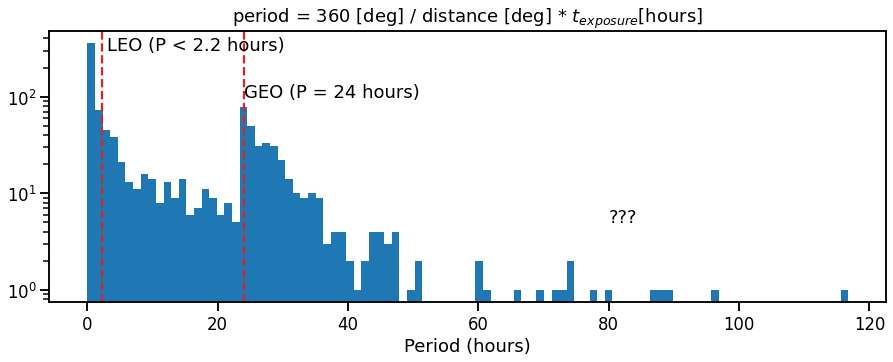

In [653]:
periods = 360. / np.array(vels)

fig = plt.figure(figsize=(15, 5))
plt.hist(periods[maskSize], bins=100)

plt.axvline(2.2, ls='--', color='C3')
plt.axvline(24, ls='--', color='C3')

plt.text(3, 300, 'LEO (P < 2.2 hours)')
plt.text(24, 100, 'GEO (P = 24 hours)')
plt.text(80, 5, '???')

plt.yscale('log')
# plt.xlim(0, None)
plt.xlabel('Period (hours)')
plt.title(r'period = 360 [deg] / distance [deg] * $t_{exposure}$[hours]')

In [659]:
classes = np.array([get_class_from_period(period) for period in periods])

print('Distribution of classes:')
print('- LEO: {:.2f} %'.format(np.sum(classes == 'LEO')/len(classes) * 100))
print('- MEO: {:.2f} %'.format(np.sum(classes == 'MEO')/len(classes) * 100))
print('- GEO: {:.2f} %'.format(np.sum(classes == 'GEO')/len(classes) * 100))
print('- Unknown: {:.2f} %'.format(np.sum(classes == 'Unknown')/len(classes) * 100))

Distribution of classes:
- LEO: 22.68 %
- MEO: 14.74 %
- GEO: 5.66 %
- Unknown: 56.93 %


## Characteristic length estimation

Let's try to estimate the characteristic length of objects, $L_c$. Assuming the object is a Lambertian sphere, we have:

$L_c = 10^{(m_{sun} - m_{abs})/5} \dfrac{R}{\sqrt{A}}\sqrt{6}$ 

where $m_{sun}$ is the apparent magnitude of the Sun, $m_{abs}$ is the absolute magnitude of the object, $R$ is the distance object-Earth, and $A$ is the albedo. Of course, we do not know the distance $R$, but we can roughly infer it from the rotation period. Let's assume:

- LEO: R=1,000 km
- MEO: R=10,000 km
- GEO: R=42,000 km

This is by no means precise, but rather order of magnitudes... For the albedo, we will assume $A=0.175$ (from https://arxiv.org/abs/2012.12549)

In [660]:
distance_dic = {'LEO': 1000., 'MEO': 20000., 'GEO': 42000., 'Unknown': np.nan}

sizes = np.array(
    [
        np.median(
            fake_lambertian_size(
                i, -26.7, distance_dic[j], 0.175
            )*1000
        ) for i, j in zip(np.array(magabs)[maskSize], classes[maskSize])
    ]
)

/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


Text(0.5, 0, 'Characteristic length $L_c$ [meter]')

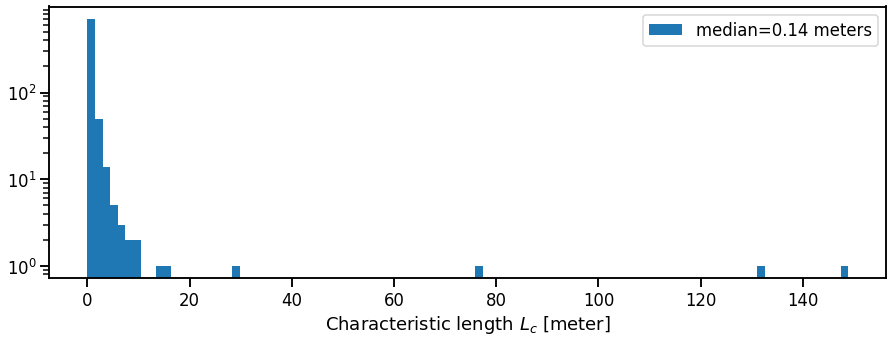

In [666]:
mask = ~np.isnan(sizes) #* (sizes < 10)

fig = plt.figure(figsize=(15, 5))

plt.hist(sizes[mask], bins=100, label='median={:.2f} meters'.format(np.median(sizes[mask])))

plt.yscale('log')
plt.legend()
plt.xlabel(r'Characteristic length $L_c$ [meter]')

Text(0.5, 0, 'Characteristic length $L_c$ [meter]')

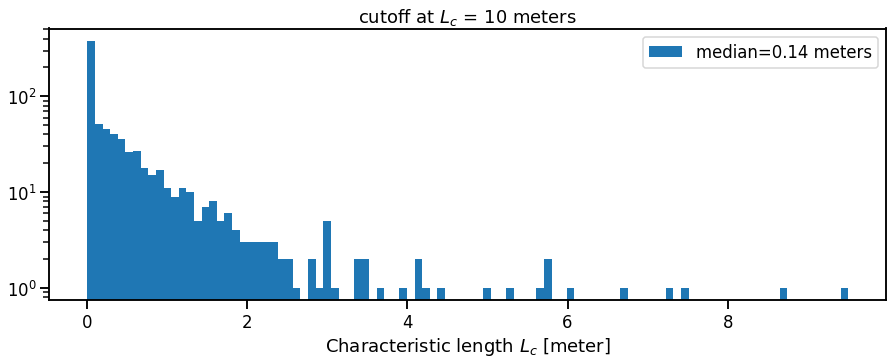

In [665]:
mask = ~np.isnan(sizes) * (sizes < 10)

fig = plt.figure(figsize=(15, 5))

plt.hist(sizes[mask], bins=100, label='median={:.2f} meters'.format(np.median(sizes[mask])))

plt.yscale('log')
plt.legend()
plt.title(r'cutoff at $L_c$ = 10 meters')
plt.xlabel(r'Characteristic length $L_c$ [meter]')

We have objects around 14 cm diameter - quite small! Some seems bigger, but I wouldn't really trust this computation...

In [683]:
# ii = np.where(sizes[mask] > 100)
# np.array(classes)[maskSize][mask][ii]
# np.array(nids)[maskSize][mask][ii], np.array(jds)[maskSize][mask][ii]

## Plotting nightly data

Just change the night ID `n` to show the tracklets for one night, and remove the `set_ylim`, `set_xlim` below. here is an interesting one!

-------
Number of alerts: 55
velocity (deg/hour): 105.98
period (hour): 3.40
0
-------
Number of alerts: 63
velocity (deg/hour): 189.51
period (hour): 1.90
795
-------
Number of alerts: 11
velocity (deg/hour): 186.36
period (hour): 1.93
1265


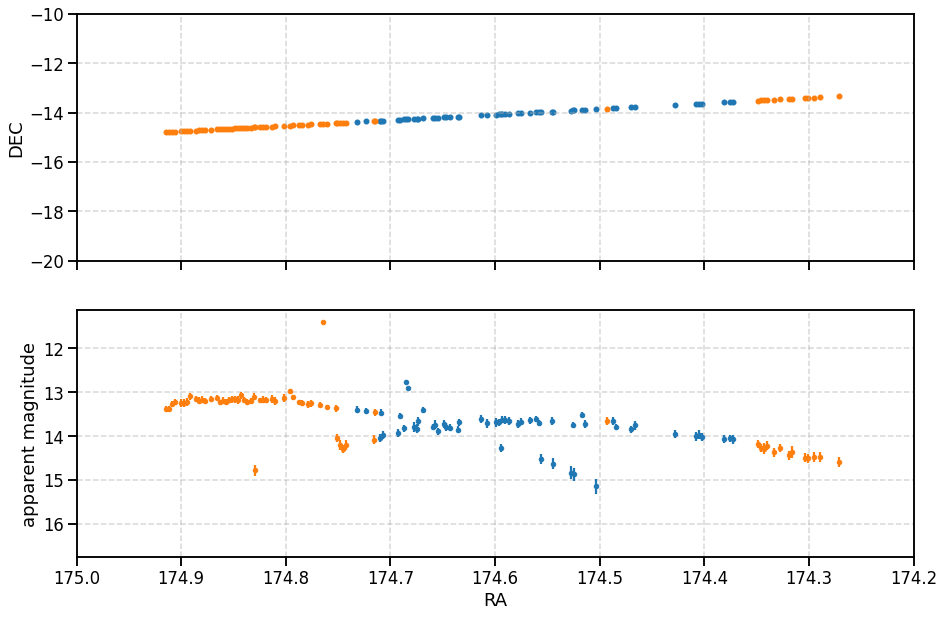

In [684]:
data = table1[cidx]
n = 1245

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
maskNight = data['nid'] == n
for k in np.unique(data[maskNight]['tracklet_number']):
    maskTracklet = data['tracklet_number'] == k
    mask = maskTracklet * maskNight

    ramean, decmean, t_iso = extract_properties(
        data['ra'][mask], 
        data['dec'][mask], 
        data['jd'][mask][0]
    )

    ax[0].scatter(
        data['ra'][mask], 
        data['dec'][mask], 
        marker='.'
    )

    vel = get_velocity_bystep(data[mask])
    print('-------')
    print('Number of alerts: {}'.format(np.sum(mask)))
    print('velocity (deg/hour): {:.2f}'.format(vel))
    period = get_period(vel)
    print('period (hour): {:.2f}'.format(period))
    print(data[mask]['tracklet_number'][0])

    mag, err = np.array(
        [
            dc_mag(*i) for i in zip(
                data[mask]['fid'],
                data[mask]['magpsf'],
                data[mask]['sigmapsf'],
                data[mask]['magnr'],
                data[mask]['sigmagnr'],
                data[mask]['magzpsci'],
                data[mask]['isdiffpos'],
            )
        ]
    ).T

    magabs_ = apparent_to_absolute(
        mag, 
        data['jd'][mask][0],
        data['ra'][mask],
        data['dec'][mask],
    )

    ax[1].errorbar(
            data['ra'][mask], 
            magabs_, 
            err, 
            marker='.', ls=''
    )

ax[0].set_ylabel('DEC')
ax[0].grid(alpha=0.5, ls='--')
ax[0].set_ylim(-20, -10)

ax[1].set_xlabel('RA')
ax[1].set_ylabel('apparent magnitude')
ax[1].set_xlim(174.2, 175)

plt.gca().invert_xaxis()
ax[1].invert_yaxis()
ax[1].grid(alpha=0.5, ls='--')
plt.show()